In [1]:
import numpy as np
import sympy
from sympy import symbols, Eq, linear_eq_to_matrix
import random
import matplotlib.pyplot as plt

from pyeda.inter import expr, exprvar, expr2bdd
from dd.autoref import BDD
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# from dd.cudd import BDD

number_of_nodes = 7


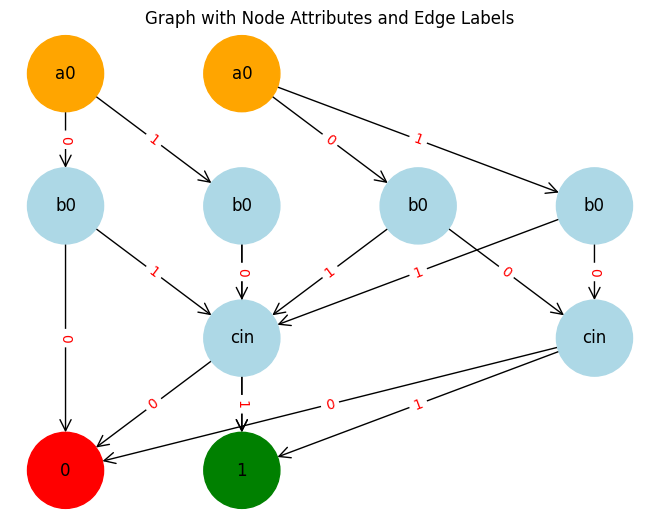

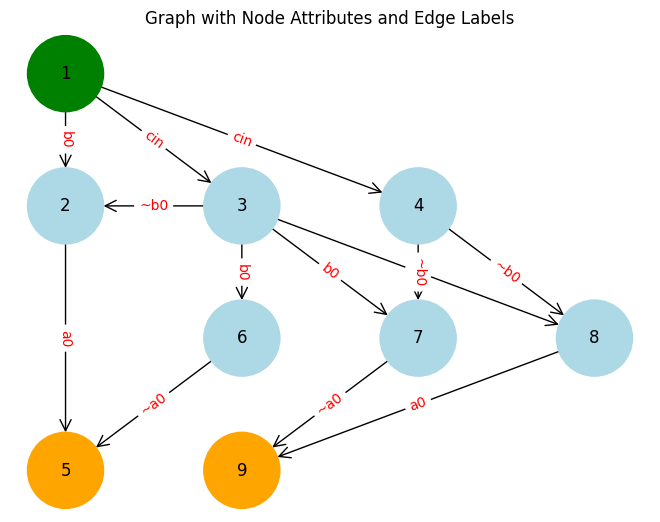

In [42]:
class PATH:
    def __init__(self):
        self.BDD = None
        self.Graph = None
        self.Expressions = None
        self.NodeIDMap = None
        self.InputNode = None

    def BooleanExpresions_to_BDD(self):
        # Initialize the BDD manager
        self.BDD = BDD()
        self.BDD.configure(reordering=True)
        
        # Declare variables
        # BDD.declare('a', 'b', 'c', 'd')
        
        # # Define Boolean expressions
        # expressions = {
        #     'P0': BDD.add_expr('a & b'),
        #     'P1': BDD.add_expr('(a & b) ^ (c & d)'),
        #     'P2': BDD.add_expr('(a & c) ^ ((a & b) & (c & d))'),
        #     'P3': BDD.add_expr('(a & c) & ((a & b) & (c & d))')
        # }
        
        self.BDD.declare('a0', 'b0', 'cin',)
        self.Expressions = {
            'c_out': self.BDD.add_expr('(a0 & b0) | (a0 & cin) | (b0 & cin)'),
            's_0': self.BDD.add_expr('a0 ^ b0 ^ cin')
        }
        
        self.BDD.collect_garbage()
        self.BDD.reorder()
        
        number_of_nodes = len(self.BDD)
        print(f'{number_of_nodes = }')

    def BDD_to_NetworkXGraph(self):
        #Traversing the BDD
        ids_lsts = []
        self.NodeIDMap = {}
        for rootKey in self.Expressions:
            queue = [self.Expressions[rootKey]]
            id_lst = set()
            while(queue):
                curr_ele = queue.pop(0)
                [lvl, node1, node2] = self.BDD.succ(curr_ele)
        
                id_lst.add((str(curr_ele),curr_ele.var, curr_ele.negated))
                if(str(curr_ele) not in self.NodeIDMap):
                    self.NodeIDMap[str(curr_ele)]=[0,set()]
                self.NodeIDMap[str(curr_ele)][0]+=1
                self.NodeIDMap[str(curr_ele)][1].add((curr_ele.var, lvl))
                
                if node1.var!=None:
                    queue.append(node1)
                else:
                    if(str(node1) not in self.NodeIDMap):
                        self.NodeIDMap[str(node1)]=[0,{('0' if node1.negated else '1', 0)}]
                    self.NodeIDMap[str(node1)][0]+=1
                    
                    # print(node1,node1.negated)
                
                if node2.var!=None:
                    queue.append(node2)
                else:
                    if(str(node2) not in self.NodeIDMap):
                        self.NodeIDMap[str(node2)]=[0,{('0' if node2.negated else '1', 0)}]
                    self.NodeIDMap[str(node2)][0]+=1
                    
                    # print(node2,node2.negated)
            ids_lsts.append(id_lst)
        
        # Initialize an undirected graph
        self.Graph = nx.DiGraph()
        ExpressionsRev = {str(self.Expressions[key]):key for key in self.Expressions}
        
        #adding nodes
        for id in self.NodeIDMap:
            literal = next(iter(self.NodeIDMap[id][1]))[0]
            level = next(iter(self.NodeIDMap[id][1]))[1]
            ExpressionRoot = None
            if(id in ExpressionsRev):
                ExpressionRoot = ExpressionsRev[id]
            attributes = {'ID': id, 'literal': literal, 'level':level, 'ExpressionRoot': ExpressionRoot}
        
            # Add nodes with attributes to the graph
            self.Graph.add_node(id, **attributes)
        
        # #Adding edges
        for rootKey in self.Expressions:
            queue = [self.Expressions[rootKey]]
            while(queue):
                curr_ele = queue.pop(0)
                [lvl, node1, node2] = self.BDD.succ(curr_ele)
                self.Graph.add_edge(str(curr_ele), str(node1), label='0')
                self.Graph.add_edge(str(curr_ele), str(node2), label='1')
                
                if node1.var!=None:
                    queue.append(node1)
                if node2.var!=None:
                    queue.append(node2)

    def GraphPreprocessing(self):
        #Re-label the edges
        for u, v, data in self.Graph.edges(data=True):
            # Retrieve the parent node's literal
            parent_literal = self.Graph.nodes[u].get('literal')
            
            # Ensure the parent_literal is valid (not None) and the edge has a label
            if parent_literal and 'label' in data:
                # Update the edge label based on the parent node's literal
                if data['label'] == '0':
                    # For '0', add a negation (~) to the parent's literal
                    data['label'] = f"~{parent_literal}"
                elif data['label'] == '1':
                    # For '1', use the parent's literal directly
                    data['label'] = parent_literal

        # Remove the node with literal='0' and id='@-1' along with its connections
        nodes_to_remove = [node for node, data in self.Graph.nodes(data=True) if data.get('literal') == '0' and data.get('ID') == '@-1']
        for node in nodes_to_remove:
            self.Graph.remove_node(node)


        #Invert all edges in the graph 
        inverted_graph = nx.DiGraph()
        inverted_graph.add_nodes_from(self.Graph.nodes(data=True))
        inverted_graph.add_edges_from([(v, u, data) for u, v, data in self.Graph.edges(data=True)])
        self.Graph = inverted_graph

        # Store the root node (in RootNode) after inversion        
        self.InputNode = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('literal')=='1' and self.Graph.in_degree(node) == 0][0]

        #Re-label the nodes
        Counter = 1
        queue = [self.InputNode]
        visited = set()
        while queue:
            current_node = queue.pop(0)

            if current_node in visited:
                continue
            visited.add(current_node)

            # Update node labels for the current node's
            self.Graph.nodes[str(current_node)]['literal'] = str(Counter)
            Counter+=1

            for _, target_node, edge_data in self.Graph.out_edges(str(current_node), data=True):
                queue.append(target_node)
        
    
    def DisplayEdgesInNetworkXGraph(self):
        # Iterate through all edges in the graph
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            # Retrieve the edge label; default to 'No label' if not present
            edge_label = data.get('label', 'No label')
            print(f"{next(iter(self.NodeIDMap[u][1]))[0]}({u}) -[{edge_label}]-> {next(iter(self.NodeIDMap[v][1]))[0]}({v})")

    def VisuvaliseNetworkXGraph(self):
        # Initialize position dictionary
        pos = {}
        
        # Parameters for positioning
        HORIZONTAL_SPACING = 1.0  # Horizontal distance between nodes
        VERTICAL_SPACING = 3.0    # Vertical distance between layers
        
        # Separate nodes into categories
        root_nodes = [node for node in self.Graph.nodes if self.Graph.in_degree(node) == 0]
        leaf_nodes = [node for node in self.Graph.nodes if self.Graph.out_degree(node) == 0]
        intermediate_nodes = [node for node in self.Graph.nodes if node not in root_nodes + leaf_nodes]
        
        # Assign positions to ExpressionRoot nodes (top layer)
        for i, node in enumerate(root_nodes):
            pos[node] = (i * HORIZONTAL_SPACING, 0)
            # print((i * HORIZONTAL_SPACING, 0))
        
        # Assign positions to Intermediate nodes based on BFS layers
        # Start BFS from all ExpressionRoot nodes
        layers = list(nx.bfs_layers(self.Graph, root_nodes))
        
        for lvl, nodes in enumerate(layers):
            # print("Layer:")
            for i, node in enumerate(nodes):
                if node in intermediate_nodes:  # Only position intermediate nodes
                    # print(next(iter(idSet[node][1]))[0], end=",")
                    pos[node] = (i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (lvl))
                    # print((i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (lvl)))
            # print("\n")

        leafnodeYaxis = len(layers)
        if(self.Graph.nodes[layers[0][0]].get('literal')=="1"):
            leafnodeYaxis = leafnodeYaxis - 1
        
        # print("Literals")
        # Assign positions to Literal nodes (bottom layer)
        for i, node in enumerate(leaf_nodes):
            pos[node] = (i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (leafnodeYaxis))
            # print((i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (leafnodeYaxis)))
        
        # Draw nodes with labels
        node_colors = []
        for node in self.Graph.nodes:
            if self.Graph.nodes[node].get('ExpressionRoot') is not None:
                node_colors.append('orange')
            elif self.Graph.nodes[node].get('literal') == '0':
                node_colors.append('red')
            elif self.Graph.nodes[node].get('literal') == '1':
                node_colors.append('green')
            else:
                node_colors.append('lightblue')  # Default color for intermediate nodes

        nx.draw(self.Graph, pos, with_labels=False, node_color=node_colors, node_size=3000, font_size=10, arrows=True, arrowstyle='->', arrowsize=20)
        
        # Draw literals as node labels
        node_labels = nx.get_node_attributes(self.Graph, 'literal')
        nx.draw_networkx_labels(self.Graph, pos, labels=node_labels, font_size=12, font_color='black')
        
        # Draw edge labels
        edge_labels = nx.get_edge_attributes(self.Graph, 'label')
        nx.draw_networkx_edge_labels(self.Graph, pos, edge_labels=edge_labels, font_color='red')
        
        
        # Display the graph
        plt.title("Graph with Node Attributes and Edge Labels")
        plt.show()

path = PATH()
path.BooleanExpresions_to_BDD()
path.BDD_to_NetworkXGraph()
path.VisuvaliseNetworkXGraph()
path.GraphPreprocessing()
path.VisuvaliseNetworkXGraph()


In [522]:
from pyeda.boolalg.expr import expr
from pyeda.boolalg.bdd import expr2bdd

# Define multiple Boolean expressions
expressions = {
    "P0": expr('a & b'),
    "P1": expr('(a & b) ^ (c & d)'),
    "P2": expr('(a & c) ^ ((a & b) & (c & d))'),
    "P3": expr('(a & c) & ((a & b) & (c & d))'),
}

# Create a variable map to map unique BDD variable IDs to their names
var_map = {}
for exp_name, exp in expressions.items():
    for v in exp.support:
        var_map[v.uniqid] = v.name

# Convert each expression into a BDD
bdds = {name: expr2bdd(exp) for name, exp in expressions.items()}

def bdd_to_tree(node, visited=None):
    """
    Recursively convert a BDD node into a tree-like dictionary structure.
    Args:
        node: Current BDD node to process
        visited: Dictionary to avoid re-processing shared subtrees
    Returns:
        A tree-like dictionary representation of the BDD.
    """
    if visited is None:
        visited = {}

    # Base case: Terminal node (0 or 1)
    if node.lo is None and node.hi is None:
        return 0 if node.root == -1 else 1

    # If the node has already been processed, return the cached result
    if node in visited:
        return visited[node]

    # Map the variable ID to its variable name using var_map
    var_name = var_map.get(node.root, f"x_{node.root}")

    # Recursively process the low and high branches
    result = {
        "var": var_name,
        "low": bdd_to_tree(node.lo, visited),
        "high": bdd_to_tree(node.hi, visited),
    }

    # Cache the result to handle shared subtrees
    visited[node] = result
    return result

# Convert all BDDs into tree-like structures
bdd_trees = {name: bdd_to_tree(bdd.node) for name, bdd in bdds.items()}

# Print the combined BDD tree representations
print("Combined BDD Tree Representations:")
for name, tree in bdd_trees.items():
    print(f"{name} BDD Tree:")
    print(tree)

Combined BDD Tree Representations:
P0 BDD Tree:
{'var': 'a', 'low': 0, 'high': {'var': 'b', 'low': 0, 'high': 1}}
P1 BDD Tree:
{'var': 'a', 'low': {'var': 'c', 'low': 0, 'high': {'var': 'd', 'low': 0, 'high': 1}}, 'high': {'var': 'b', 'low': {'var': 'c', 'low': 0, 'high': {'var': 'd', 'low': 0, 'high': 1}}, 'high': {'var': 'c', 'low': 1, 'high': {'var': 'd', 'low': 1, 'high': 0}}}}
P2 BDD Tree:
{'var': 'a', 'low': 0, 'high': {'var': 'b', 'low': {'var': 'c', 'low': 0, 'high': 1}, 'high': {'var': 'c', 'low': 0, 'high': {'var': 'd', 'low': 1, 'high': 0}}}}
P3 BDD Tree:
{'var': 'a', 'low': 0, 'high': {'var': 'b', 'low': 0, 'high': {'var': 'c', 'low': 0, 'high': {'var': 'd', 'low': 0, 'high': 1}}}}


In [146]:
from pyeda.boolalg.expr import expr
from pyeda.boolalg.bdd import expr2bdd

# Create a Boolean expression
expression = expr('a & b & c | d & a')

var_map = {}
for v in expression.support:
    # internally each exprvar has a BDD var as well
    var_map[v.uniqid] = v.name

# Convert the expression to a BDD
bdd = expr2bdd(expression)

def bdd_to_tree(node, visited=None):
    if visited is None:
        visited = {}
    if node.lo is None and node.hi is None:
        return 0 if node.root == -1 else 1

    if node in visited:
        return visited[node]

    # print(node.root)
    var_name = f"x_{node.root}"
    var_name = var_map.get(node.root,None)

    result = {
        "var": var_name,
        "low": bdd_to_tree(node.lo, visited),
        "high": bdd_to_tree(node.hi, visited),
    }
    visited[node] = result
    return result


bdd_tree = bdd_to_tree(bdd.node)

# Print the BDD tree representation
print("BDD Tree Representation:")
print(bdd_tree)

BDD Tree Representation:
{'var': 'a', 'low': 0, 'high': {'var': 'b', 'low': {'var': 'd', 'low': 0, 'high': 1}, 'high': {'var': 'c', 'low': {'var': 'd', 'low': 0, 'high': 1}, 'high': 1}}}


In [159]:
from collections import deque, defaultdict

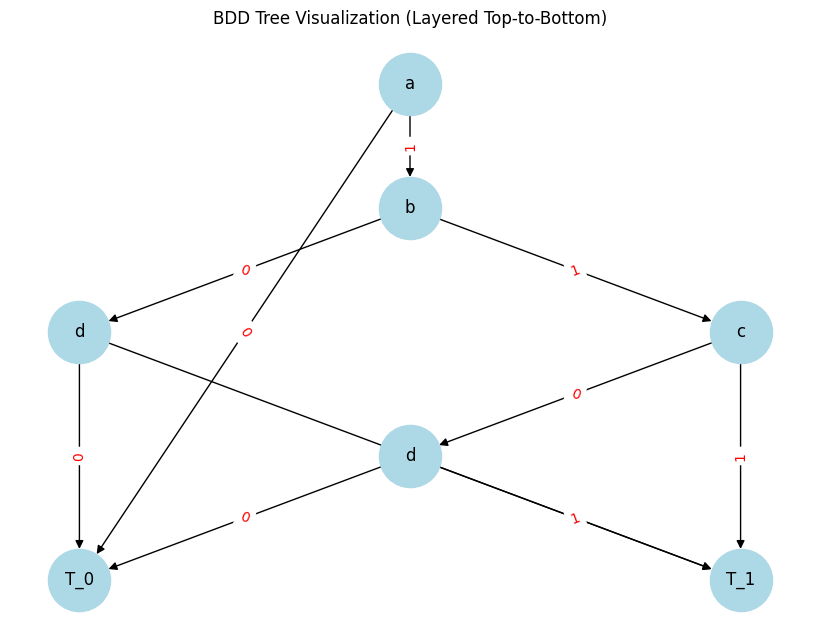

Edge: a -> T_0, label = 0
Edge: a -> b, label = 1
Edge: b -> d, label = 0
Edge: b -> c, label = 1
Edge: d -> T_0, label = 0
Edge: d -> T_1, label = 1
Edge: c -> d, label = 0
Edge: c -> T_1, label = 1
Edge: d -> T_0, label = 0
Edge: d -> T_1, label = 1
______________________________


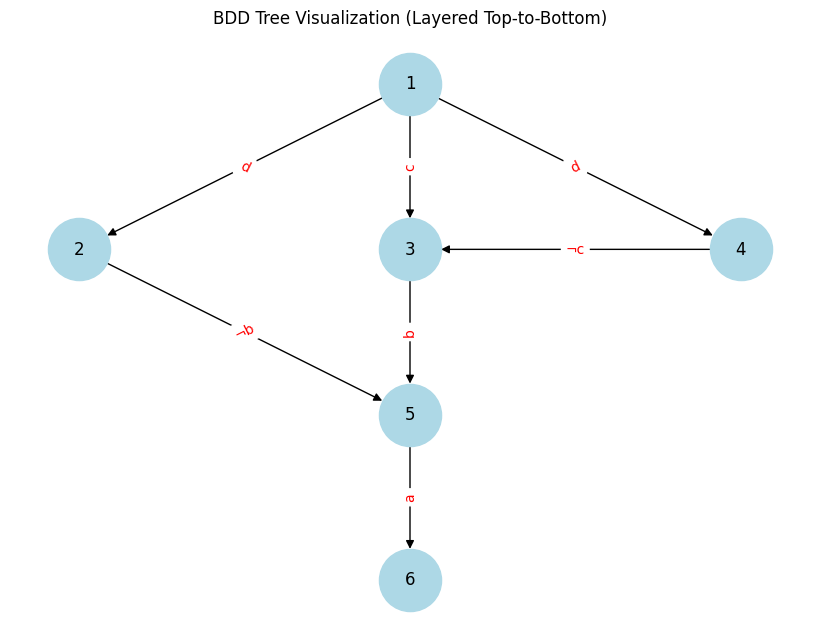

Edge: 1 -> 2, label = d
Edge: 1 -> 3, label = c
Edge: 1 -> 4, label = d
Edge: 2 -> 5, label = ¬b
Edge: 3 -> 5, label = b
Edge: 4 -> 3, label = ¬c
Edge: 5 -> 6, label = a
______________________________


Edge: 1 -> 2, label = d
Edge: 1 -> 3, label = c
Edge: 1 -> 4, label = d
Edge: 2 -> 5, label = ¬b
Edge: 3 -> 5, label = b
Edge: 4 -> 3, label = ¬c
Edge: 5 -> 6, label = a
______________________________


Edge: 1 -> 2, label = d
Edge: 1 -> 3, label = c
Edge: 1 -> 4, label = d
Edge: 2 -> 5, label = ¬b
Edge: 3 -> 5, label = b
Edge: 4 -> 3, label = ¬c
Edge: 5 -> 6, label = a



In [236]:
class TreeNode:
    """
    A simple node in our BDD-based binary tree.
    Each node holds:
      - var: the variable name or label (e.g., "a", "b", "c")
      - low: either 0, 1, or another TreeNode
      - high: either 0, 1, or another TreeNode
    """
    def __init__(self, var, low=None, high=None):
        self.var = var
        self.low = low
        self.high = high


class BDDTree:
    """
    A class representing a BDD-like binary tree.
    Stores:
      - root: reference to the top-level TreeNode (or 0/1 if it's just a terminal).
    """
    def __init__(self):
        self.root = None
        self.processed_tree = None
        # For storing bipartite graph after transformation
        self.U1 = {}  # dict:  bddNodeID -> label (or var)
        self.U2 = {}  # dict:  bipartiteEdgeNodeID -> (sourceID, targetID, literal)
        self.F  = []  # list of edges in bipartite graph: (u1, u2) or (u2, u1)

    def Graph_Creation(self, bdd_dict):
        """
        Build the tree from a nested dictionary and store in self.root.
        """
        self.root = self._build_node(bdd_dict)

    def _build_node(self, data):
        """
        Recursively build a TreeNode (or return 0/1) from the given nested dictionary.
        """
        # If the data is 0 or 1, that is a terminal
        if data == 0 or data == 1:
            return data

        # Otherwise, build an internal TreeNode
        var_name = data["var"]         # e.g. "a", "b", "c"
        low_data = data["low"]         # could be 0, 1, or another dict
        high_data = data["high"]       # could be 0, 1, or another dict

        low_node = self._build_node(low_data)
        high_node = self._build_node(high_data)

        return TreeNode(var_name, low_node, high_node)

    def draw_bdd_tree(self):
        """
        Draw the BDD that is stored in a NetworkX DiGraph 'self.processed_tree'
        in a layered (top-to-bottom) style.
        We do a BFS from the root node (in-degree=0) and assign each node to a level.
        """
    
        # 1) Check if the graph exists and has nodes
        if self.processed_tree is None or len(self.processed_tree) == 0:
            print("No graph to draw in self.processed_tree.")
            return
    
        # 2) Identify root node(s): those with in_degree=0
        root_candidates = [n for n in self.processed_tree.nodes() 
                           if self.processed_tree.in_degree(n) == 0]
    
        if not root_candidates:
            print("No root node found in self.processed_tree (no node has in_degree=0).")
            return
    
        # For simplicity, just pick the first root candidate if multiple
        root = root_candidates[0]
    
        # 3) BFS from root to assign level
        queue = deque([root])
        visited = set([root])
        level_map = {root: 0}

        rootIsTerminal = True if root in (0, 1) else False
            
        while queue:
            cur_node = queue.popleft()
            cur_level = level_map[cur_node]
    
            # For each child (successor) of cur_node...
            for nxt_node in self.processed_tree.successors(cur_node):
                if nxt_node not in visited:
                    visited.add(nxt_node)
                    queue.append(nxt_node)
                    level_map[nxt_node] = cur_level + 1

        if(rootIsTerminal==False):
            level_map[0], level_map[1] = cur_level+1, cur_level+1
    
        # 4) Optionally invert the level to put the root at the top 
        #    (so the largest level is at the bottom).
        max_level = max(level_map.values()) if level_map else 0
        for node in level_map:
            level_map[node] = max_level - level_map[node]
    
        # 5) Group nodes by their BFS level
        level_to_nodes = defaultdict(list)
        for node, lvl in level_map.items():
            level_to_nodes[lvl].append(node)
    
        # 6) Assign (x, y) positions to each level
        HORIZONTAL_SCALE = 2.0  # Increase this for more spread
        pos = {}
        for lvl in sorted(level_to_nodes.keys()):
            nodes_this_level = level_to_nodes[lvl]
            # Number of nodes at this level
            width = len(nodes_this_level)
            
            # We’ll center them horizontally around x=0 by offsetting each index i
            # so that the middle node is near x=0, and then multiply by HORIZONTAL_SCALE
            for i, node in enumerate(nodes_this_level):
                # Shift so 0 is in the middle of the set of nodes for this level
                x_offset = i - (width - 1) / 2.0
                x_coord = x_offset * HORIZONTAL_SCALE
                y_coord = -lvl  # your existing vertical spacing
        
                pos[node] = (x_coord, y_coord)
    
        # 7) Gather node labels
        #    If your graph has an attribute "label" or "nodelabel", use that for display.
        node_label_map = {}
        for n, data in self.processed_tree.nodes(data=True):
            node_label_map[n] = data.get("nodelabel", str(n))
    
        # 8) Gather edge labels
        edge_label_map = {}
        for u, v, edata in self.processed_tree.edges(data=True):
            edge_label_map[(u, v)] = edata.get("edgelabel", "")
    
        # 9) Draw the graph with matplotlib
        plt.figure(figsize=(8, 6))
        nx.draw(
            self.processed_tree,
            pos=pos,
            labels=node_label_map,
            with_labels=True,
            arrows=True,
            node_size=2000,
            node_color="lightblue",
            arrowstyle="-|>",
            arrowsize=12
        )
        nx.draw_networkx_edge_labels(
            self.processed_tree,
            pos,
            edge_labels=edge_label_map,
            font_color="red"
        )
    
        # Flip the y-axis so that the root is visually at the top
        plt.gca().invert_yaxis()
    
        plt.title("BDD Tree Visualization (Layered Top-to-Bottom)")
        plt.axis("off")
        plt.show()

    def copy_bddTree_to_NetworkXTree(self):
        """
        Recursively copy the subtree rooted at 'node'.
        Return the root of the new copy.
        """
        if self.root is None:
            print("No tree to copy.")
            return

        # Build a directed graph in NetworkX
        self.processed_tree = nx.DiGraph()

        def get_label(node):
            """Return a string label for a node (terminal or internal)."""
            if node in (0, 1):
                return f"T_{node}"
            return str(node.var)

        def add_edge(u, v, edge_name):
            """Helper to add directed edge u->v with an 'edgelabel'."""
            self.processed_tree.add_edge(u, v, edgelabel=edge_name)
            
        # We’ll do a BFS from the root, assigning level = distance from root.
        queue = deque()
        level_map = {}     # node -> integer level
        visited = set()
        
        self.processed_tree.add_node(self.root)
        self.processed_tree.nodes[self.root]["nodelabel"] = get_label(self.root)
        level_map[self.root] = 0
        queue.append(self.root)
        visited.add(self.root)
        
        # BFS
        while queue:
            cur_node = queue.popleft()

            # 'low' child
            low_child = cur_node.low
            if low_child not in (0,1):
                if low_child not in visited:
                    visited.add(low_child)
                    queue.append(low_child)
                    self.processed_tree.add_node(low_child)
                    self.processed_tree.nodes[low_child]["nodelabel"] = get_label(low_child)
                add_edge(cur_node, low_child, "0")
            else:
                # Terminal
                if low_child not in self.processed_tree:
                    self.processed_tree.add_node(low_child)
                    self.processed_tree.nodes[low_child]["nodelabel"] = get_label(low_child)
                add_edge(cur_node, low_child, "0")

            # 'high' child
            high_child = cur_node.high
            if high_child not in (0,1):
                if high_child not in visited:
                    visited.add(high_child)
                    queue.append(high_child)
                    self.processed_tree.add_node(high_child)
                    self.processed_tree.nodes[high_child]["nodelabel"] = get_label(high_child)
                add_edge(cur_node, high_child, "1")
            else:
                # Terminal
                if high_child not in self.processed_tree:
                    self.processed_tree.add_node(high_child)
                    self.processed_tree.nodes[high_child]["nodelabel"] = get_label(high_child)
                add_edge(cur_node, high_child, "1")

    def Edges_labels(self):
        """
        1) Build/copy the original BDD graph into a new NetworkX DiGraph (G2).
        2) For each edge labeled '¬var' or 'var', create additional edges:
             - If label = '¬a', then from node '0' to '~a', and from '~a' to the target
             - If label = 'a',  then from node '1' to 'a',  and from 'a' to the target
        3) Relabel every node with a unique integer ID.
        """
        # 1) Check if the graph exists and has nodes
        if self.processed_tree is None or len(self.processed_tree) == 0:
            print("No graph to draw in self.processed_tree.")
            return
    
        # 2) Identify root node(s): those with in_degree=0
        root_candidates = [n for n in self.processed_tree.nodes() 
                           if self.processed_tree.in_degree(n) == 0]
    
        if not root_candidates:
            print("No root node found in self.processed_tree (no node has in_degree=0).")
            return
    
        # For simplicity, just pick the first root candidate if multiple
        root = root_candidates[0]
    
        # 3) BFS from root to assign level
        queue = deque([root])
        visited = set([root])

        while queue:
            cur_node = queue.popleft()
    
            # For each child (successor) of cur_node...
            for nxt_node in self.processed_tree.successors(cur_node):
                if nxt_node not in visited:
                    visited.add(nxt_node)
                    queue.append(nxt_node)
                    
                edge_label = self.processed_tree.edges[cur_node, nxt_node]['edgelabel']
                print(f"Edge: {self.processed_tree.nodes[cur_node]['nodelabel']} -> {self.processed_tree.nodes[nxt_node]['nodelabel']}, label = {edge_label}")

    #--------------------------------------------------------------------------
    # 2) Graph Graph_Preprocessing: build graph with re-labling
    #--------------------------------------------------------------------------
    def Graph_Preprocessing(self):
        """
        1) Build/copy the original BDD graph into a new NetworkX DiGraph (G2).
        2) For each edge labeled '¬var' or 'var', create additional edges:
             - If label = '¬a', then from node '0' to '~a', and from '~a' to the target
             - If label = 'a',  then from node '1' to 'a',  and from 'a' to the target
        3) Relabel every node with a unique integer ID.
        """
        # 1) Check if the graph exists and has nodes
        if self.processed_tree is None or len(self.processed_tree) == 0:
            print("No graph to draw in self.processed_tree.")
            return

        # --------------------------------------------
        # PART C: Remove node(s) labeled 'T_0' or '0'
        # --------------------------------------------
        nodes_to_remove = []
        for n, data in list(self.processed_tree.nodes(data=True)):
            label = data['nodelabel']
            # If it was never relabeled as an integer, it might still be 'T_0' (string).
            if label == 'T_0' or label == '0':
                nodes_to_remove.append(n)
    
        for nd in nodes_to_remove:
            self.processed_tree.remove_node(nd)
    
        # 2) Identify root node(s): those with in_degree=0
        root_candidates = [n for n in self.processed_tree.nodes() 
                           if self.processed_tree.in_degree(n) == 0]
    
        # For simplicity, just pick the first root candidate if multiple
        root = root_candidates[0]
    
        # 3) BFS from root to assign level
        queue = deque([root])
        visited = set([root])
        while queue:
            cur_node = queue.popleft()
    
            # For each child (successor) of cur_node...
            for nxt_node in self.processed_tree.successors(cur_node):
                if nxt_node not in visited:
                    visited.add(nxt_node)
                    queue.append(nxt_node)

                if(self.processed_tree.edges[cur_node, nxt_node]['edgelabel']=="0"):
                    self.processed_tree.edges[cur_node, nxt_node]['edgelabel'] = '¬'+(self.processed_tree.nodes[cur_node]['nodelabel'])
                elif(self.processed_tree.edges[cur_node, nxt_node]['edgelabel']=="1"):
                    self.processed_tree.edges[cur_node, nxt_node]['edgelabel'] = (self.processed_tree.nodes[cur_node]['nodelabel'])

        # --------------------------------------------
        # PART D: Reverse all edges in-place
        # --------------------------------------------
        self.processed_tree = nx.reverse(self.processed_tree, copy=False)

        # --------------------------------------------
        # PART E: Number all the edges
        # --------------------------------------------
        # 2) Identify root node(s): those with in_degree=0
        root_candidates = [n for n in self.processed_tree.nodes() 
                           if self.processed_tree.in_degree(n) == 0]
        root = root_candidates[0]
        queue = deque([root])
        visited = set([root])
        counter = 1
        while queue:
            cur_node = queue.popleft()
            
            self.processed_tree.nodes[cur_node]['nodelabel'] = counter
            counter+=1
    
            # For each child (successor) of cur_node...
            for nxt_node in self.processed_tree.successors(cur_node):
                if nxt_node not in visited:
                    visited.add(nxt_node)
                    queue.append(nxt_node)  

    #--------------------------------------------------------------------------
    # 3) Graph Transformation: build bipartite sets U1 (BDD nodes) and U2 (edges).
    #--------------------------------------------------------------------------
    def Graph_Transformation(self):
        print()
        
    def Bipartite_Graph_Visuvalisation(self):
        print()
        
    #--------------------------------------------------------------------------
    # 3) Node Merging: compress all edges from a given U1 node with the same literal
    #    into one single node in U2.
    #--------------------------------------------------------------------------
    def Node_Merging(self):
        """
        Implements the 'node merging' from Section VI-C of the paper.
        We detect multiple edges from the same U1 node with the same literal
        and merge them into a single U2 node.
        """
        print()

    #--------------------------------------------------------------------------
    # 4) Visualize final bipartite graph after node merging
    #--------------------------------------------------------------------------
    def visualize_bipartite(self):
        """
        Print a simple textual summary of the bipartite graph after node merging:
           U1 nodes (BDD nodes) -> U2 nodes (edge-nodes) -> U1
        """
        print("\nFinal Bipartite Graph (U1, U2, F):\n")
    
    #--------------------------------------------------------------------------
    # Optional Crossbar_Realization or other steps
    #--------------------------------------------------------------------------
    def Crossbar_Realization(self, n):
        """
        Placeholder for crossbar array building.
        """
        ResitanceStates = [[0 for i in range(n)] for i in range(n)]
        return ResitanceStates


if __name__ == "__main__":
    # This is the dictionary you produced from your BDD code:

    # Create the BDDTree and load it from the dict
    tree = BDDTree()
    
    # 0) Build BDD from dict
    tree.Graph_Creation(bdd_tree)
    tree.copy_bddTree_to_NetworkXTree()
    tree.draw_bdd_tree()
    tree.Edges_labels()
    print('______________________________')

    # 1) Preprocess BDD graph to relabel nodes and edges
    tree.Graph_Preprocessing()
    tree.draw_bdd_tree()
    tree.Edges_labels()
    print('______________________________')
    
    # 2) Convert to bipartite
    tree.Graph_Transformation()
    tree.Bipartite_Graph_Visuvalisation()
    tree.Edges_labels()
    print('______________________________')
    
    # 3) Merge nodes with identical labels from the same BDD node
    tree.Node_Merging()
    tree.Bipartite_Graph_Visuvalisation()
    tree.Edges_labels()
    print('______________________________')
    
    # Realization of crossbar
    # tree.Crossbar_Realization()

In [19]:
def idealCurrentPath(Resistance_matrix, Output_lines):
    
    OutputPaths = {(Output_line-1, Output_line-1):[] for Output_line in Output_lines}

    # Custom function to emulate an ordered set using a list
    def add_to_ordered_set(ordered_set, element):
        if element not in ordered_set:
            ordered_set.append(element)
    
    # Stack for depth-first traversal
    Stack = []
    
    # Finding paths
    for j in range(len(Resistance_matrix[0])):
        if Resistance_matrix[0][j] == R_LRS:
            Stack.append([(0, j), [(0, j)], 'w'])  # Use a list for ordered visited nodes
    
    while Stack:
        [(path_i, path_j), visited, last_curr] = Stack.pop()  # Pop from the stack (LIFO)
        for i in range(8):
            if last_curr == 'w':
                if Resistance_matrix[i][path_j] == R_LRS and (i, path_j) not in visited:
                    new_visited = visited.copy()
                    add_to_ordered_set(new_visited, (i, path_j))
                    Stack.append([(i, path_j), new_visited, 'b'])
            elif last_curr == 'b':
                if Resistance_matrix[path_i][i] == R_LRS and (path_i, i) not in visited:
                    new_visited = visited.copy()
                    add_to_ordered_set(new_visited, (path_i, i))
                    Stack.append([(path_i, i), new_visited, 'w'])
        if((path_i, path_j) in OutputPaths):
            OutputPaths[(path_i, path_j)] = visited

    return OutputPaths

In [20]:
# Resistor parameters
R_Off       = 1e9    # Very large (transistor off)
R_HRS       = 2e6    # High-resistance state of the memory cell
R_LRS       = 5000    # Low-resistance state (example, or swap values as needed)
R_Line_Out  = 2e2    # 200 ohms from each column node to GND (example)
R_Not       = 1e9

# Resitance matrix
Resitance_matrix = [
      #1       2      3     4      5      6      7      8
    [R_LRS, R_HRS, R_HRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS],
    [R_HRS, R_HRS, R_LRS, R_HRS, R_LRS, R_HRS, R_HRS, R_HRS],
    [R_HRS, R_LRS, R_LRS, R_LRS, R_HRS, R_LRS, R_HRS, R_HRS],
    [R_LRS, R_HRS, R_HRS, R_LRS, R_HRS, R_LRS, R_HRS, R_HRS],
    [R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS],
    [R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS],
    [R_LRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_LRS, R_HRS],
    [R_HRS, R_LRS, R_HRS, R_HRS, R_HRS, R_HRS, R_HRS, R_LRS],
]

# Close transistor gate connected to uncharged selector lines
Selector_lines = {1:1, 2:1, 3:1, 4:1, 5:0, 6:0, 7:1, 8:1}
for j in Selector_lines:
    for i in range(len(Resitance_matrix)):
        if(Selector_lines[j]!=1):
            Resitance_matrix[i][j-1] = R_Off

#Output lines
Output_lines = [7, 8]

OutputPaths = idealCurrentPath(Resitance_matrix, Output_lines)

AllOutputPaths =  [item for sublist in OutputPaths.values() for item in sublist]

# 1. row voltages and column voltages as symbolic variables
Vr = sympy.symbols('Vr1 Vr2 Vr3 Vr4 Vr5 Vr6 Vr7 Vr8', real=True)
Vc = sympy.symbols('Vc1 Vc2 Vc3 Vc4 Vc5 Vc6 Vc7 Vc8', real=True)

# Voltages together in a single list for convenience
x_vars = list(Vr) + list(Vc)

#Voltage source
Vsrc = 0.2



# 2. Build the 16 KCL equations (8 row and 8 column equations to find their voltage)
equations = []

for i in range(8):
    if(i==0):   #First wordline connected to voltage source
        eq_i = sympy.Eq(Vr[i], Vsrc)
    else:
        row_crossbar_sum = 0
        for j in range(8):
            row_crossbar_sum += 1/Resitance_matrix[i][j] * (Vr[i] - Vc[j])
        eq_i = sympy.Eq(row_crossbar_sum, 0)
    equations.append(eq_i)

for j in range(8):
    if(j+1 in Output_lines):
        col_to_ground = Vc[j] / R_Line_Out
    else:
        col_to_ground = Vc[j] / R_Not
        
    col_crossbar_sum = 0
    for i in range(8):
        col_crossbar_sum += 1/Resitance_matrix[i][j] * (Vc[j] - Vr[i])
    eq_j = sympy.Eq(col_to_ground + col_crossbar_sum, 0)
    equations.append(eq_j)

# ----------------------------------------------------------------
# 3) Solve the system A*x = b
A, b = sympy.linear_eq_to_matrix(equations, x_vars)
solution = A.LUsolve(b)

Voltages = {}

for var, val in zip(x_vars, solution):
    Voltages[f"{var}"] = val.evalf()*1000
    
currentInDevices = [[0 for _ in range(8)] for _ in range(8)]
for i in range(8):
    for j in range(8):
        currentInDevices[i][j] = (Voltages['Vr'+str(i+1)]-Voltages['Vc'+str(j+1)])/Resitance_matrix[i][j]

OutputPaths

{(6, 6): [(0, 0), (6, 0), (6, 6)],
 (7, 7): [(0, 0), (3, 0), (3, 3), (2, 3), (2, 1), (7, 1), (7, 7)]}

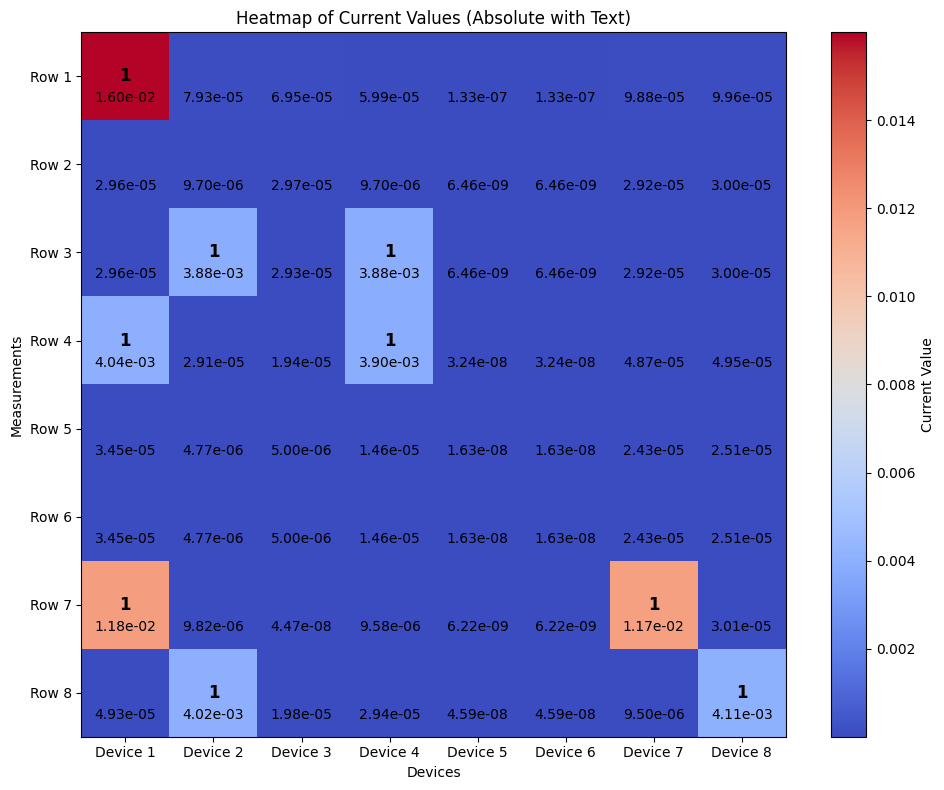

In [21]:
# Converting all numbers in currentInDevices to their absolute values
currentInDevices_abs = [[abs(value) for value in row] for row in currentInDevices]

# Convert to a numeric numpy array
data = np.array(currentInDevices_abs, dtype=float)

# Re-plotting the heatmap with absolute values and displaying text on each cell
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Current Value')

# Add text annotations on each cell
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if((i,j) in AllOutputPaths):
            plt.text(j, i, "1", ha='center', va='center', color='black', fontsize=12, fontweight='bold')
        plt.text(j, i+0.25, f"{data[i, j]:.2e}", ha='center', va='center', color='black')

# Add labels and title
plt.title("Heatmap of Current Values (Absolute with Text)")
plt.xlabel("Devices")
plt.ylabel("Measurements")
plt.xticks(ticks=np.arange(data.shape[1]), labels=[f"Device {i+1}" for i in range(data.shape[1])])
plt.yticks(ticks=np.arange(data.shape[0]), labels=[f"Row {i+1}" for i in range(data.shape[0])])

# Show the plot
plt.tight_layout()
plt.show()

In [22]:
pip install pyeda

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyeda: filename=pyeda-0.29.0-cp39-cp39-win_amd64.whl size=185985 sha256=73002234e8ab765aab7f9140dc8d6dd1674158cf8fe1ac0f8d9e0b0e029f9174
  Stored in directory: c:\users\nithi\appdata\local\pip\cache\wheels\ed\e8\bf\2b4b34552fe29059a46ecb0ca16f8f4f6eb9d61798ce3cf97e
Successfully built pyeda
Note: you may need to restart the kernel to use updated packages.


TypeError: copy_bddTree_to_NetworkXTree() missing 1 required positional argument: 'node'